# TDO objects after Haberlie et al. (2015)

This is a Python implementation of the algorithm presentend in Haberlie et al. (2015) aiming on finding newly developing convective areas.

The basic idea of the algorithm is, to detect long-living newly developing convectively acitve areas in a stack of weather radar data. Covnectively active and inactive areas are separated using a threshold, e.g. Z > 35 dBZ. This means, all areas having a radar reflectivety above this threshold are considered a convectively active area. Newly developed areas and areas already having been active for a longer time are separated using distance buffering with a given distance around the already active areas. Every newly developed pixel having a radar reflectivety above the threshold and being outside a buffer is considered a new coectively active object. These new objects are than tracked using overlap tracking for a given amount of time steps (seven in the original). If they are still active after this given time they are saved as acitve "time domain objects" (TDO).

To start, there have some packages to be includes. This impelementation needs numpy, scipy, scikit-image, matplotlib and copy.

In [23]:
%matplotlib inline
import numpy as np

from scipy import ndimage as ndi
from skimage import morphology 

import copy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

The weather radar data has to be loaded, which ideally has been masked previously using the radar threshold.In this example we load RADOLAN data of 28th June 2012 11:00 am util 11:30 am. This is a time frame consisting of seven time steps. To do so, we have to include some additional packages.

In [2]:
from io_tools import radolan as rado
import datetime

After this, we create a list containig the needed timsteps.

In [3]:
start_time = datetime.datetime(2012,7,28,11,0)
end_time = datetime.datetime(2012,7,28,11,35)

time_list = []
    
while start_time <= end_time:
    time_list.append(start_time)
    start_time += datetime.timedelta(minutes=5)

Now we load the radar data and mask them using a radar threshold of Z = 35 dBZ.

In [4]:
radar_threshold = 35
rado_stack = []

for t in time_list:
    r = rado.Radolan()
    r.read(t,rproduct='rx_hdcp2')
    Z = r.data
    Zm = np.ma.masked_where(Z < radar_threshold,Z)

    rado_stack.append(Zm)

The next step is to buffer the masked data of the first time step. We select 15 km as the buffer radius.

In [9]:
buffer_radius = 15

kernel = morphology.disk(buffer_radius)
binary_field = ~rado_stack[0].mask * 1

buffered_t0 = ndi.morphology.binary_dilation(binary_field==1,structure=kernel)

Now we are looking for the really new convectively active pixels in the next timestep. To do so, we start with picking all pixels which could be interesting.

In [10]:
convectively_active_pixels_t1 = ~rado_stack[1].mask * 1

Then we check which pixels are inside the buffers of the first timestep.

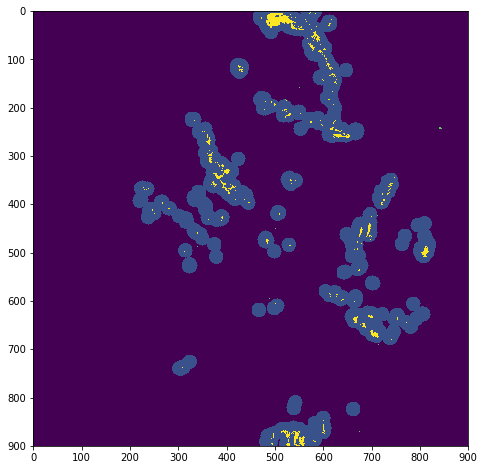

In [24]:
buffer_check = buffered_t0 + convectively_active_pixels_t1*3 

plt.imshow(buffer_check)

Now all actual new developed pixels not being inside a buffer should have the value of three, while buffer pixels = 1 and new new pixels inside the buffers have a value of four. To separate interesting pixels from the others, everything not being equal to three is set to zero and than the whole array is divided by three. Now only interesting pixels should remain and have a value of one.

In [18]:
convective_initiation_t1 = buffer_check.copy() 
    
convective_initiation_t1[np.where(convective_initiation_t1!=3)] = 0
convective_initiation_t1 = convective_initiation_t1 / 3 

Plotting to check visually if there are new interesting pixels:

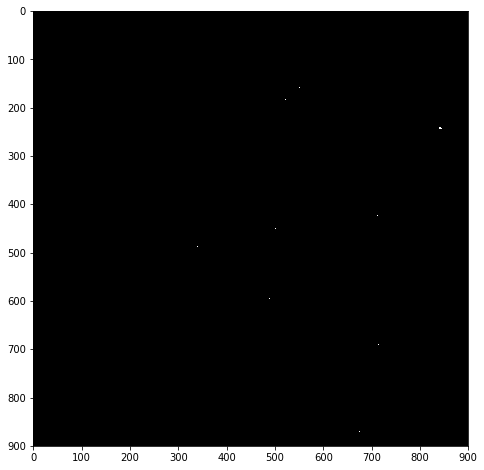

In [25]:
plt.imshow(convective_initiation_t1,cmap='gray',interpolation='none')

Indeed, there are areas which could be interesting.

So, we construct a stack out of this layer and the next time steps.

In [20]:
analysis_stack = [convective_initiation_t1]
   
for i in xrange(2,len(time_list)):
        analysis_stack.append(~rado_stack[i].mask*1)

Now we perform a three dimensional conneted component labeling on this stack using a 26 neighbourhood to track interesting pixels.

In [21]:
 clustered, clusternumber = ndi.measurements.label(analysis_stack, structure=morphology.cube(3))

In doing so, there are new objects in all time steps. But we are interested in the objects of the first timestep, only. Therefore we extract the labeling and pixel count of those.

In [22]:
labels, counts = np.unique(clustered[0],return_counts=True) 
print labels,counts

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [809949      1      1      2      1      1      3     20      1      7
      1      1      1      8      2      1]


In this case there are 15 different objects in the first timestep. Zero labels the background. Most of them are rather small but there are also large ones. Those can be new objects but also some which migrated into the area covered by the radar network.

As we now know the labeling of all interesting objects of the first time step, we can remove all objects having developed later.

In [26]:
convective_clusters = copy.deepcopy(clustered)

for i in xrange(1,len(convective_clusters)):
    convective_clusters[i][np.where(convective_clusters[i]>np.max(labels))] = 0

Than we can check which of those objects having developed in the first time step remained until the last one.

In [27]:
convective_index = np.unique(convective_clusters[-1])
convective_index_list = convective_index.tolist()
convective_index_list.remove(0) # remove background

print(convective_index_list)

[6, 7, 13]


In this case there are three objects.

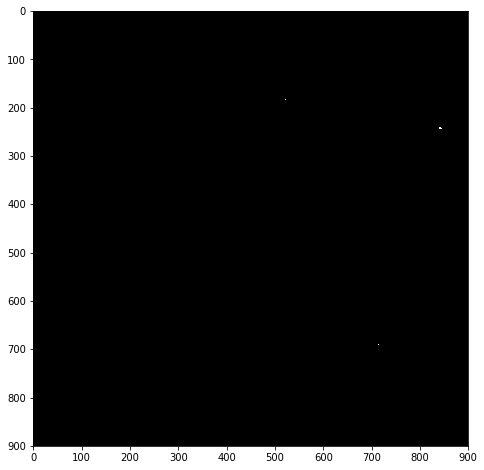

In [28]:
objekte_t1 = copy.deepcopy(clustered[0])

objekte_t1[np.where(objekte_t1<6)] = 0
objekte_t1[np.where(np.logical_and(objekte_t1>7,objekte_t1<13))] = 0
objekte_t1[np.where(objekte_t1>13)] = 0
objekte_t1[np.where(objekte_t1!=0)] = 1

plt.imshow(objekte_t1,cmap="gray",interpolation='none')

The next steps could be to derive the cetroids of those objects or the obejcts themelves.